In [2]:
# general
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt

# loss
from sklearn.metrics import mean_squared_error

# model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import itertools


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

# Q1: Importing and Visualizing Binding Affinity Data [1 pt]

1. Load the dataset from Max.txt.
2. Plot a histogram of binding affinity values.
3. Describe any patterns, trends, or anomalies you observe in the distribution?

In [3]:
file_path = '/Users/peytonhall/Documents/spring_2025/qbio_465/assignment_1/Max.txt'
max_data = pd.read_csv(file_path, sep='\t', header=None)
max_data.columns = ['sequence', 'binding_strength']
max_data

,sequence,binding_strength
0,GAAGCCCTGGCGGGGCGCGTGCCCGCCGCCGCCGCC,3.737829
1,TCCCGGGGCTAGAGGCATGTGGACTCAGGAGGATGA,3.895754
2,GGCGCTGCCGGACTGCGCGTGGAGTGGCGCGCTGCT,3.797545
3,GCAGCTCGCCCGGGCCACGCGGTGCCGGCCCTCGGC,4.080446
4,GGAATTACCTTCATCCACATGGTTGAAGCTGGCTGG,4.126748
...,...,...
8563,AGCAAAGCTGGCCCCCACGTTGTCCTTCCGCAGAAC,4.010130
8564,GGGACCCTGCCTTCCCGCGTGGCCGCACCGAGACGA,4.036789
8565,AGAAGAACCCGGGCGCACGTGGCCGACTCCAGGCTG,4.418053
8566,GGGGCCCGGGTGGGGCATGTGGGGACAACGCCTGGA,3.939968


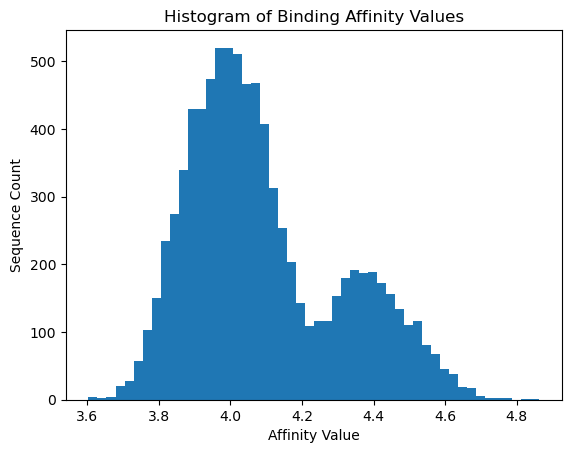

In [4]:
plt.hist(max_data.iloc[:,1], bins=50)
plt.xlabel('Affinity Value')
plt.ylabel('Sequence Count')
plt.title('Histogram of Binding Affinity Values')
plt.show()

Regarding the distribution, it seems to be right-skewed towards an affinity of around 4.0. 

However, there is another increase in the occurence of affinities around 4.4. 

# Q2: One-Hot Encoding of k-mers [2 pts]

1. Implement a function that takes a DNA sequence and an integer k as input and returns a
one-hot encoded vector representing all k-mers.

In [5]:
# Function: k_mer_encode
# Parameters: sequence and k for k-mer(1,2,3,4)
# returns: array of encoded seq with k as k-mer

def k_mer_encode(seq, k):
    # possible nt
    nt= ["A", "C", "T", "G"]
    
    # permutation/enumerate
    k_mers= {''.join(kmer) : i for i, kmer in enumerate(itertools.product(nt, repeat=k))}
    
    # matrix
    identity_matrix= np.identity(4**k)
    
    # encode
    encoding= [identity_matrix[k_mers[seq[i: i+k]]] for i in range(len(seq)-k+1)]
    return np.concatenate(encoding)

2. Use this function to generate the one-hot encoded representation for the sequence
'AACTGCGT' with k=2.

In [6]:
k_mer_encode('AACTGCGT', 2)

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

3. Apply this function to encode all DNA sequences in the dataset.
Example Encoding (1-mer and 2-mer representations):

1-mer Encoding:
○ 'A' → [1000]
○ 'C' → [0100]
○ 'G' → [0010]
○ 'T' → [0001]


2-mer Encoding:
○ 'AA' → [1000000000000000]
○ 'AC' → [0100000000000000]
○ 'TT' → [0000000000000001]

In [7]:
# make sequence and affinity vars
sequence = max_data["sequence"]
affinity = max_data["binding_strength"]

In [8]:
# scale affinity 
# min-max normalization function
def normalizationFunct(shape):
    minShape = np.min(shape, axis=0)  # Minimum for each column
    maxShape = np.max(shape, axis=0)  # Maximum for each column
    y = (shape - minShape) / (maxShape - minShape)
    return y

In [9]:
affinity_normal = normalizationFunct(affinity)
affinity_normal

0       0.106881
1       0.232205
2       0.154269
3       0.378770
4       0.415513
          ...   
8563    0.322970
8564    0.344125
8565    0.646682
8566    0.267292
8567    0.720506
Name: binding_strength, Length: 8568, dtype: float64

In [10]:
# 1mer encode max
encoded_mono_max = np.array([k_mer_encode(i,1) for i in sequence])

In [11]:
# check shape
encoded_mono_max.shape
# good, 144/4 = 36 bp long to start

(8568, 144)

In [12]:
# 2mer encode max
encoded_di_max = np.array([k_mer_encode(i,2) for i in sequence])

In [13]:
# check shape
encoded_di_max.shape

(8568, 560)

# Q3: Effect of Regularization on a 1-mer Model [2 pts]

1. Train a linear regression model using one-hot encoded 1-mer representations and
compute the training and test loss.

In [14]:
def lin_regress(seq,affinity):
    # split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(seq, affinity, test_size=0.2, random_state=22)
    
    # initialize model
    model = LinearRegression()
    
    # fit model
    model.fit(X_train, y_train)
    
    # make predictions on training and testing data
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # train and test loss via mse
    mse_train_loss = mean_squared_error(y_train, train_pred)
    mse_test_loss = mean_squared_error(y_test, test_pred)
    
    return mse_train_loss, mse_test_loss

In [15]:
print("Training and testing loss, respectively:")
lin_regress(encoded_mono_max,affinity_normal)

Training and testing loss, respectively:


(0.006064540359966593, 0.00633911345547404)

2. Apply L2 regularization (Ridge regression) with different values of alpha:
○ alpha = 0 (no regularization)
○ alpha = 0.1 (small regularization)
○ alpha = 10 (large regularization)

In [16]:
def ridge_regression(seq, affinity):
    # split data
    X_train, X_test, y_train, y_test = train_test_split(seq, affinity, test_size=0.2, random_state=22)
    
    # alpha values
    alphas = [0, 0.1, 10]
    train_losses = []
    test_losses = []
    
    for alpha in alphas:
        # initialize ridge
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)
        
        # predictions
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        # compute losses
        train_losses.append(mean_squared_error(y_train, train_pred))
        test_losses.append(mean_squared_error(y_test, test_pred))
    
    # plot
    plt.figure(figsize=(8, 5))
    plt.plot(alphas, train_losses, label='Training Loss', marker='o')
    plt.plot(alphas, test_losses, label='Test Loss', marker='o')
    plt.xlabel('Alpha Values')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Effect of L2 Regularization on Training and Test Loss')
    plt.legend()
    plt.show()
    
    # print
    print("Training Losses:", train_losses)
    print("Test Losses:", test_losses)

3. Plot a line graph with:
○ X-axis: Alpha values
○ Y-axis: Mean Squared Error (MSE)
○ Separate lines: Training loss and test loss

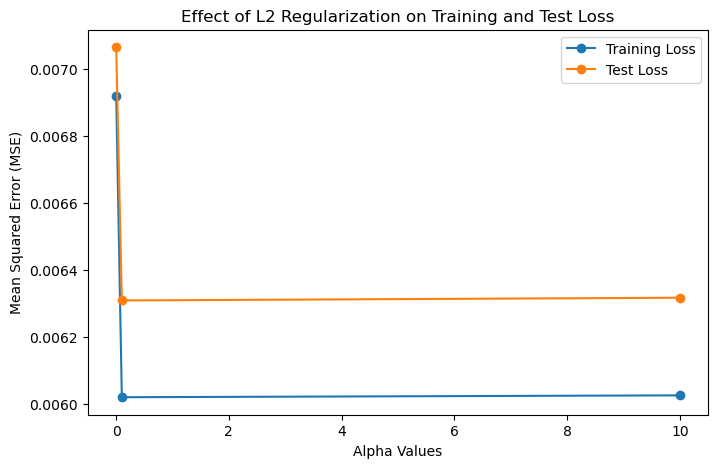

Training Losses: [0.006919814254636896, 0.00602118218492724, 0.0060267469777646855]
Test Losses: [0.007064325229530768, 0.006309576561103513, 0.006317680995314124]


In [17]:
ridge_regression(encoded_mono_max,affinity_normal)

4. Answer the following questions:
○ How do different values of alpha affect training and test loss?
○ Does regularization help improve the model in this case? Explain your
observations.

Different values of alpha decrease testing and training loss. Regularization helped improve the model in this case. My observations is that regularization with alpha tuning helped to improve model performance, but regularization without tuning didn't seem to perform better than linear regression alone. 

# Q4: Examining Model Complexity (1-mer to 4-mer) (2 pts)

1. Train four linear regression models using one-hot encoded representations for:
○ 1-mer, 2-mer, 3-mer, and 4-mer

In [18]:
#1mer data
encoded_mono_max

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [19]:
#now get 3mer and 4mer data
encoded_3_max = np.array([k_mer_encode(i,3) for i in sequence])
encoded_4_max = np.array([k_mer_encode(i,4) for i in sequence])

In [20]:
mer_encodings = {
    "1mer": encoded_mono_max,
    "2mer": encoded_di_max,
    "3mer": encoded_3_max,
    "4mer": encoded_4_max
}

train_mse = []
test_mse = []
labels = []

In [21]:
for k_mer_label, X_encoded in mer_encodings.items():
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, affinity_normal, test_size=0.2, random_state=22)
    
    # initialize and fit 
    model = LinearRegression()
    model= model.fit(X_train, y_train)
    
    # compute pred
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # get loss
    mse_train_loss = mean_squared_error(y_train, train_pred)
    mse_test_loss = mean_squared_error(y_test, test_pred)
    
    # loss lists for plot
    train_mse.append(mse_train_loss)
    test_mse.append(mse_test_loss)
    labels.append(k_mer_label)

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(labels, train_mse, marker='o', label="Training Loss", linestyle='dashed')
plt.plot(labels, test_mse, marker='s', label="Testing Loss")
plt.xlabel("Model Complexity (k-mer)")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.title("MSE vs. Model Complexity")
plt.ylim(0,0.1)
plt.show()

The training loss appears to decrease as complexity increases. However, the testing loss increases as complexity increases, as there is STRONG overfitting around 4mer since there is more noise with poor generalization. Overfitting may be addressed through R2 regression.

In [ ]:
# Elastic Net regularization to account for overfitting 
elastic_net = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000)
elastic_net.fit(X_train, y_train)

y_train_pred = elastic_net.predict(X_train)
y_test_pred = elastic_net.predict(X_test)

train_mse_q4 = mean_squared_error(y_train, y_train_pred)
test_mse_q4 = mean_squared_error(y_test, y_test_pred)

print(f"Elastic Net Regression: Train MSE = {train_mse_q4:.4f}, Test MSE = {test_mse_q4:.4f}")

# Elastic Net MSE plot
plt.plot(['1-mer', '2-mer', '3-mer', '4-mer'], train_mse, marker='o', label="Train MSE")
plt.plot(['1-mer', '2-mer', '3-mer', '4-mer'], test_mse, marker='o', label="Test MSE")
plt.xlabel("Model Complexity (k-mer size)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Elastic Net Regularization: Effect of Model Complexity")
plt.legend()
plt.show()

The 3-mer model best balances bias and variance, capturing meaningful patterns without overfitting. The 4-mer model, even with regularization, retains some variance, while the 1-mer and 2-mer models suffer from high bias and underfitting.

*note the run times went longer for the last two plots but were able to run. 